In [219]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
    

## Preprocessing

We transform the csv file into a pandas dataframe

In [220]:
df_cases = pd.read_csv('time_series_covid19_confirmed_global.csv').transpose()
df_cases.columns = df_cases.iloc[1]
df_cases = df_cases.iloc[4:]
df_cases.index = pd.to_datetime(df_cases.index,format='%m/%d/%y')
df_cases.index.name = 'Date'
df_cases.head()
#TODO - some countries have different entries for different regions, need to decide whether to countseparately (and rename) or merge.


Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Australia,...,Burundi,Sierra Leone,Netherlands,Malawi,United Kingdom,France,South Sudan,Western Sahara,Sao Tome and Principe,Yemen
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0


In [248]:
df_deaths = pd.read_csv('time_series_covid19_deaths_global.csv').transpose()
df_deaths.columns = df_deaths.iloc[1]
df_deaths = df_deaths.iloc[4:]
df_deaths.index = pd.to_datetime(df_deaths.index,format='%m/%d/%y')
df_deaths.index.name = 'Date'
df_deaths.head()


Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Australia,...,Burundi,Sierra Leone,Netherlands,Malawi,United Kingdom,France,South Sudan,Western Sahara,Sao Tome and Principe,Yemen
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [249]:
df_recovered = pd.read_csv('time_series_covid19_recovered_global.csv').transpose()
df_recovered.columns = df_recovered.iloc[1]
df_recovered = df_recovered.iloc[4:]
df_recovered.index = pd.to_datetime(df_recovered.index,format='%m/%d/%y')
df_recovered.index.name = 'Date'
df_recovered.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Australia,...,Burundi,Sierra Leone,Netherlands,Malawi,United Kingdom,France,South Sudan,Western Sahara,Sao Tome and Principe,Yemen
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##  We use a Prohet model to predict the last 10 values for 'US'

How Prophet works

At its core, the Prophet procedure is an additive regression model with four main components:

    A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
    A yearly seasonal component modeled using Fourier series.
    A weekly seasonal component using dummy variables.
    A user-provided list of important holidays.

TODO: compare how model performs on y, vs on log(y) 
Perhaps we should be directly working on log(y)

In [221]:
from fbprophet import Prophet
m = Prophet()

prophet_df = pd.DataFrame(df_cases['US'])
prophet_df['ds'] = prophet_df.index
prophet_df['y'] = prophet_df['US']
prophet_df = prophet_df.reset_index()[['ds','y']]

prophet_df['y'] = prophet_df['y'].astype('int')

prophet_df['ds'].apply(lambda x: x.to_pydatetime())

m.fit(prophet_df.iloc[:-10])
prediction = m.predict(prophet_df.iloc[-10:])



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [222]:
np.array(list(prediction['yhat']))-np.array(list(prophet_df['y'].iloc[-10:]))


array([-27328.67958044, -29807.9265296 , -28206.95140109, -27723.06655641,
       -29110.40819338, -33395.84252242, -38479.18512343, -46178.43838675,
       -46629.68533591, -44962.7102074 ])

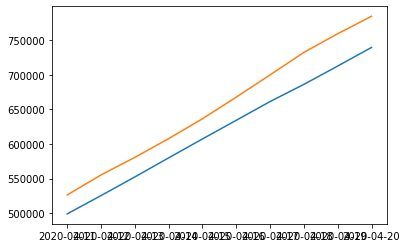

In [223]:
plt.plot(prediction['ds'],prediction['yhat'])
plt.plot(prediction['ds'],prophet_df['y'].iloc[-10:])

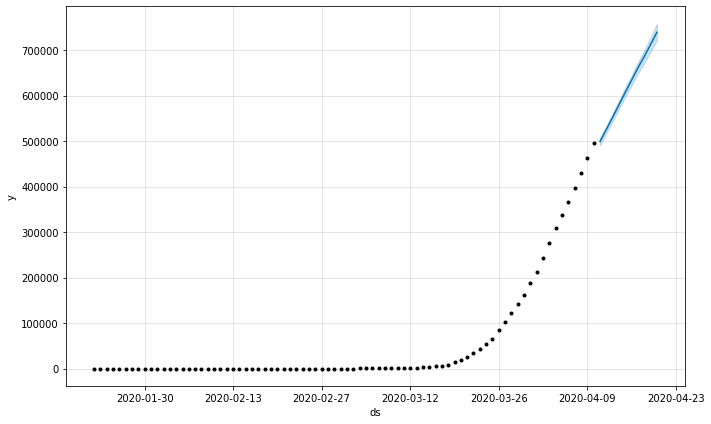

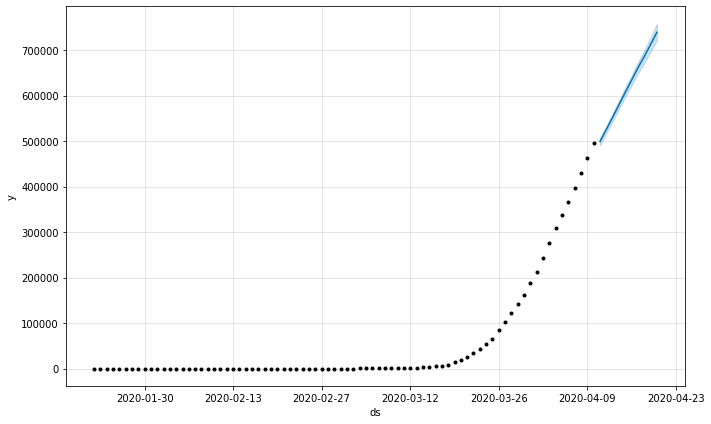

In [224]:
m.plot(prediction)

In [225]:
#TODO : Parameter tune prophet
#TODO : DEFINITELY WORK ON THE LOG OF THE DATA
m = Prophet()

prophet_df['y'] = prophet_df['y'].apply(lambda x : np.log(x))

m.fit(prophet_df.iloc[:-10])
prediction = m.predict(prophet_df.iloc[-10:])
#results are not great

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


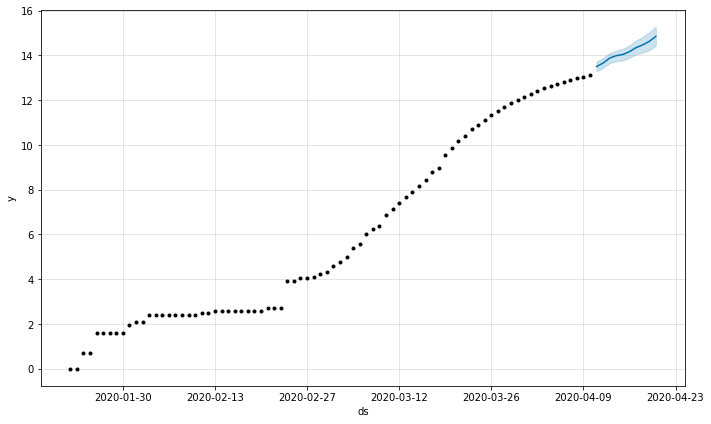

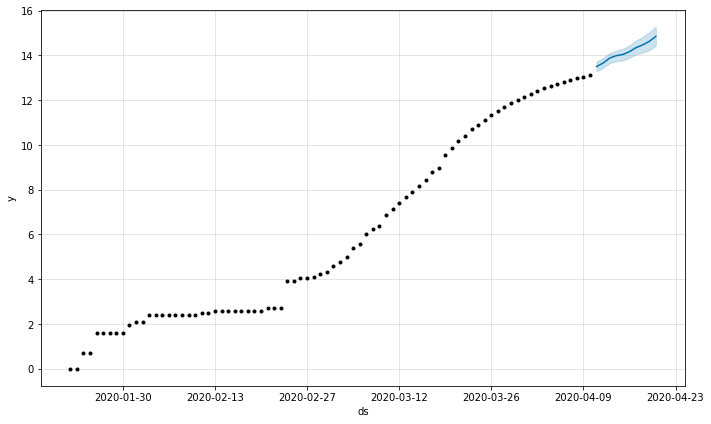

In [226]:
m.plot(prediction)

In [ ]:
#Observations
- Some plots have 0 for a long time, that is useless. The model should work from 1st case or first 20 cases (or sth similar)
- These start dates will vary for each country...
- Since there is not really a seasonal effect, prophet might not be best adapted
- Different countries are at different stages of quarantine
- If we use on fit per country, we are not really learning from all of the curves we have (i.e from countries which are more advanced)
- We could use the beginning of the curve to determine similarity between countries and have one fit for each group 
of similar countries
- model that learns from superposition of multiple curves

## Data Exploration

Find regions with most cases, plot their curves and see if prophet works

In [227]:
from datetime import datetime

In [228]:
df_cases.sum(axis=0).sort_values(ascending=False).head(20)


Country/Region
US                11167787.0
China              4794650.0
Italy              4182363.0
Spain              3890764.0
Germany            2967115.0
France             2489286.0
Iran               1885221.0
United Kingdom     1676296.0
Turkey             1073406.0
Switzerland         634115.0
Belgium             630855.0
Netherlands         573292.0
Korea, South        465192.0
Brazil              462746.0
Russia              357425.0
Austria             350334.0
Portugal            346295.0
Canada              256610.0
Israel              241506.0
Sweden              239678.0
dtype: float64

Text(0.5, 1.0, 'Percentage of total cases')

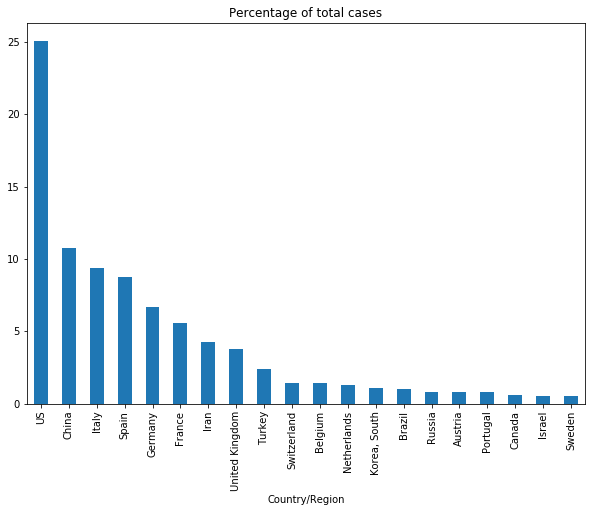

In [229]:
#What if we reason in terms of total cases
plt.figure(figsize = (10,7))
total_nb = sum(df_cases.sum(axis=0))
df_cases.sum(axis=0).apply(lambda x: x/total_nb*100).sort_values(ascending=False).iloc[:20].plot.bar()
plt.title('Percentage of total cases')

In [231]:
df_cases['China'].sum(axis=1)

Date
2020-01-22      548.0
2020-01-23      643.0
2020-01-24      920.0
2020-01-25     1406.0
2020-01-26     2075.0
               ...   
2020-04-16    83403.0
2020-04-17    83760.0
2020-04-18    83787.0
2020-04-19    83805.0
2020-04-20    83817.0
Length: 90, dtype: float64

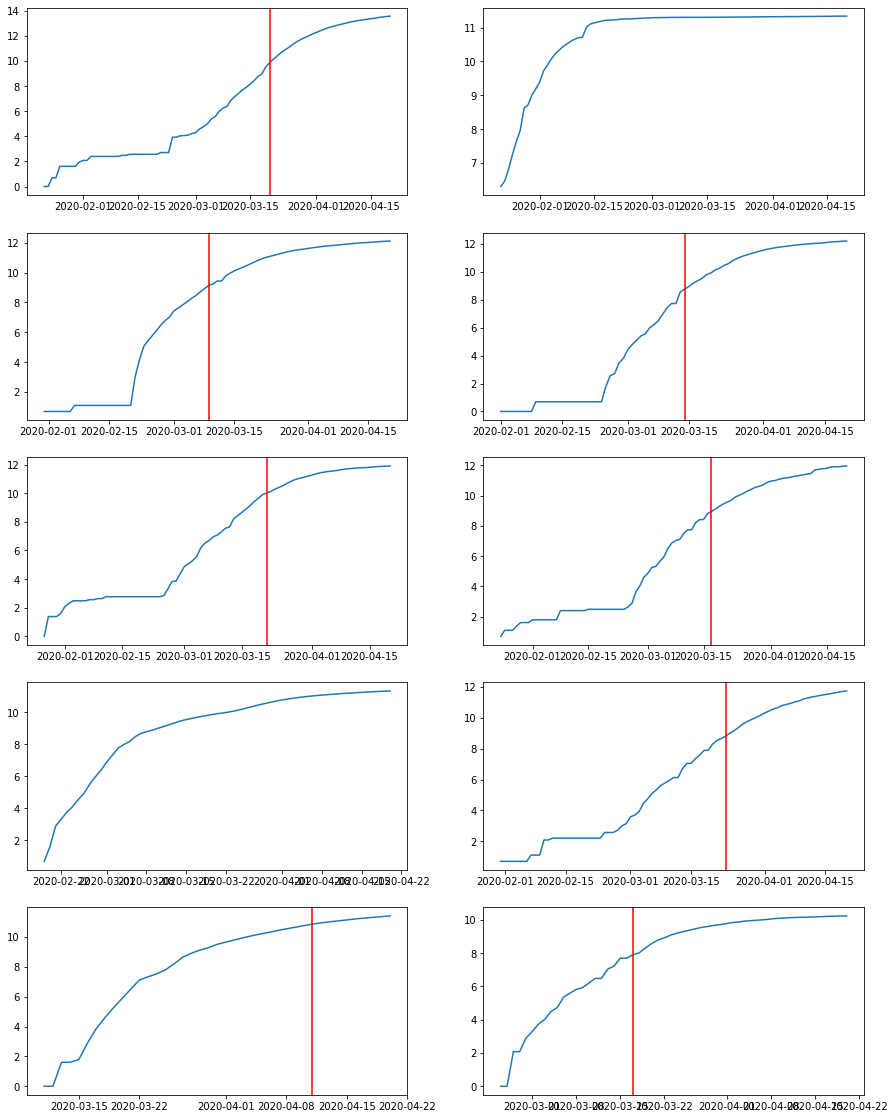

In [242]:
fig, axes = plt.subplots(5, 2,figsize = (15,20))
ax11, ax12, ax21, ax22, ax31, ax32,ax41, ax42, ax51, ax52 = axes.ravel()
ax11.plot(df_cases.index,df_cases['US'].apply(lambda x : np.log(x)))
ax11.axvline(datetime(2020,3,20),color='red')
ax12.plot(df_cases.index,df_cases['China'].sum(axis=1).apply(lambda x : np.log(x)))
ax21.plot(df_cases.index,df_cases['Italy'].apply(lambda x : np.log(x)))
ax21.axvline(datetime(2020,3,9),color='red')
ax22.plot(df_cases.index,df_cases['Spain'].apply(lambda x : np.log(x)))
ax22.axvline(datetime(2020,3,14),color='red')
ax31.plot(df_cases.index,df_cases['Germany'].apply(lambda x : np.log(x)))
ax31.axvline(datetime(2020,3,21),color='red')
ax32.plot(df_cases.index,df_cases['France'].sum(axis=1).apply(lambda x : np.log(x)))
ax32.axvline(datetime(2020,3,17),color='red')
ax41.plot(df_cases.index,df_cases['Iran'].apply(lambda x : np.log(x)))
ax42.plot(df_cases.index,df_cases['United Kingdom'].sum(axis=1).apply(lambda x : np.log(x)))
ax42.axvline(datetime(2020,3,23),color='red')
ax51.plot(df_cases.index,df_cases['Turkey'].apply(lambda x : np.log(x)))
ax51.axvline(datetime(2020,4,11),color='red')
ax52.plot(df_cases.index,df_cases['Switzerland'].apply(lambda x : np.log(x)))
ax52.axvline(datetime(2020,3,17),color='red')


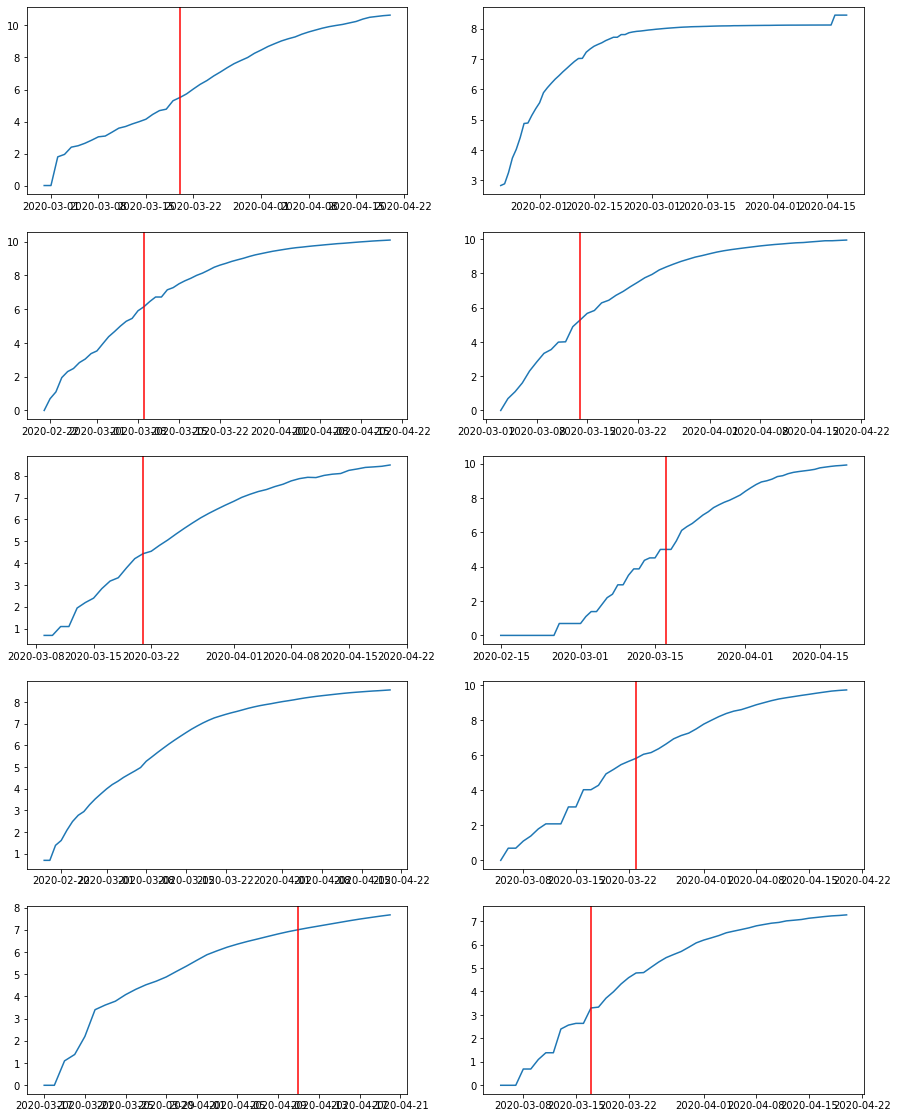

In [250]:
fig, axes = plt.subplots(5, 2,figsize = (15,20))
ax11, ax12, ax21, ax22, ax31, ax32,ax41, ax42, ax51, ax52 = axes.ravel()
ax11.plot(df_deaths.index,df_deaths['US'].apply(lambda x : np.log(x)))
ax11.axvline(datetime(2020,3,20),color='red')
ax12.plot(df_deaths.index,df_deaths['China'].sum(axis=1).apply(lambda x : np.log(x)))
ax21.plot(df_deaths.index,df_deaths['Italy'].apply(lambda x : np.log(x)))
ax21.axvline(datetime(2020,3,9),color='red')
ax22.plot(df_deaths.index,df_deaths['Spain'].apply(lambda x : np.log(x)))
ax22.axvline(datetime(2020,3,14),color='red')
ax31.plot(df_deaths.index,df_deaths['Germany'].apply(lambda x : np.log(x)))
ax31.axvline(datetime(2020,3,21),color='red')
ax32.plot(df_deaths.index,df_deaths['France'].sum(axis=1).apply(lambda x : np.log(x)))
ax32.axvline(datetime(2020,3,17),color='red')
ax41.plot(df_deaths.index,df_deaths['Iran'].apply(lambda x : np.log(x)))
ax42.plot(df_deaths.index,df_deaths['United Kingdom'].sum(axis=1).apply(lambda x : np.log(x)))
ax42.axvline(datetime(2020,3,23),color='red')
ax51.plot(df_deaths.index,df_deaths['Turkey'].apply(lambda x : np.log(x)))
ax51.axvline(datetime(2020,4,11),color='red')
ax52.plot(df_deaths.index,df_deaths['Switzerland'].apply(lambda x : np.log(x)))
ax52.axvline(datetime(2020,3,17),color='red')


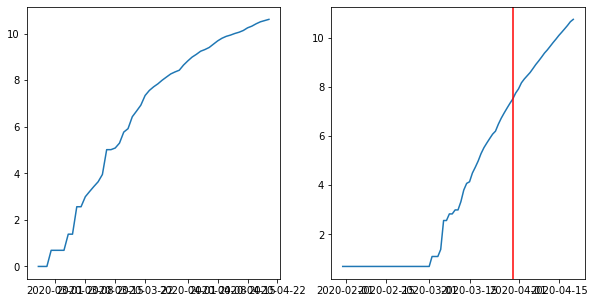

In [244]:
fig, axes = plt.subplots(1, 2,figsize = (10,5))
ax11, ax12 = axes.ravel()
ax11.plot(df_cases.index,df_cases['Brazil'].apply(lambda x : np.log(x)))
ax12.plot(df_cases.index,df_cases['Russia'].apply(lambda x : np.log(x)))
ax12.axvline(datetime(2020,3,30),color='red')


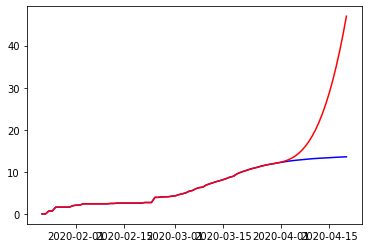

In [207]:
from scipy.interpolate import CubicSpline 
cs = CubicSpline(range(len(list(df_cases.index))-20),list(df_cases['US'].apply(lambda x : np.log(x)).iloc[:-20]))
plt.figure()
plt.plot(df_cases.index,df_cases['US'].apply(lambda x : np.log(x)),color='b')
plt.plot(df_cases.index,cs(range(len(list(df_cases.index)))),color='r')

In [274]:
y

[-inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 0.0,
 0.0,
 0.0,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 1.3862943611198906,
 1.3862943611198906,
 2.5649493574615367,
 2.5649493574615367,
 2.995732273553991,
 3.2188758248682006,
 3.4339872044851463,
 3.6375861597263857,
 3.9512437185814275,
 5.017279836814924,
 5.017279836814924,
 5.087596335232384,
 5.298317366548036,
 5.771441123130016,
 5.918893854273146,
 6.431331081933479,
 6.675823221634848,
 6.928537818164665,
 7.343426229147367,
 7.562161631225652,
 7.717351272185329,
 7.845416036592485,
 8.001355025826703,
 8.136518252115291,
 8.269756947532983,
 8.35608503102148,
 8.429235912657095,
 8.651199471263972,
 8.829958044235482,
 8.992681750892542,
 9.111182800442965,
 9.245707515813473,
 9.317

In [289]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt

def logistic(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

y = df_cases['Brazil'].loc[df_cases['Russia'] > 0].apply(lambda x : max(0,np.log(x)))
y = list(y)
x = list(range(len(y)))

#finds optimal parameters for logistic curve and defines f as the optimal curve
(a,b,c,d),_ = opt.curve_fit(logistic, x[:40], y[:40])
f = lambda x: logistic(x,a,b,c,d)


C:\Users\Max Tchibozo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning:

overflow encountered in exp

C:\Users\Max Tchibozo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning:

overflow encountered in exp



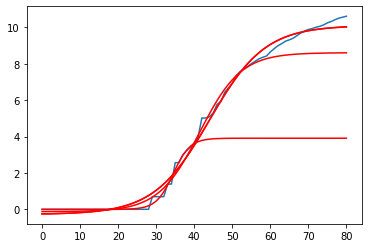

In [291]:
plt.plot(x,y)
(a,b,c,d),_ = opt.curve_fit(logistic, x[:40], y[:40])
f = lambda x: logistic(x,a,b,c,d)
plt.plot(x,f(x),color='r')

(a,b,c,d),_ = opt.curve_fit(logistic, x[:60], y[:60])
f = lambda x: logistic(x,a,b,c,d)
plt.plot(x,f(x),color='r')

(a,b,c,d),_ = opt.curve_fit(logistic, x[:80], y[:80])
f = lambda x: logistic(x,a,b,c,d)
plt.plot(x,f(x),color='r')

plt.plot(x,f(x),color='r')


[1.59869437e-01 3.58228946e-01 4.24130402e-01 3.89212360e-01
 3.26786931e-01 6.49635034e-01 9.97722310e-02 2.90757673e-01
 1.85673424e-01 1.93195365e-01 3.35426482e-01 1.70222196e-01
 1.84339874e-01 1.46231440e-01 1.08573279e-01 1.09015514e-01
 7.62876112e-02 7.87170826e-02 6.14675775e-02 4.68612368e-02
 8.36843742e-03 2.91300487e-01 1.02471297e-01 3.04985388e-02
 3.02342249e-02 2.68787124e-02 2.42365847e-02 5.48277931e-03
 6.11908707e-03 6.28043518e-03 1.90237201e-02 2.72686549e-04
 2.83930881e-03 6.61959255e-03 5.28477372e-03 5.53692904e-03
 4.16434506e-03 5.40801399e-03 7.23221474e-03 2.54891809e-03
 1.55863296e-03 1.55620740e-03 1.87667449e-03 1.89794570e-03
 9.90957594e-04 6.55969032e-04 4.57685726e-04 3.33854727e-04
 4.20251168e-04 1.35925809e-04 1.60615777e-04 3.95252040e-04
 3.21027290e-04 3.70288088e-04 3.08468702e-04 5.42673916e-04
 6.65606651e-04 1.15759283e-03 6.76694068e-04 1.59764075e-03
 7.73324043e-04 1.14048170e-03 8.57569945e-04 1.48063878e-03
 1.40518966e-03 1.244691

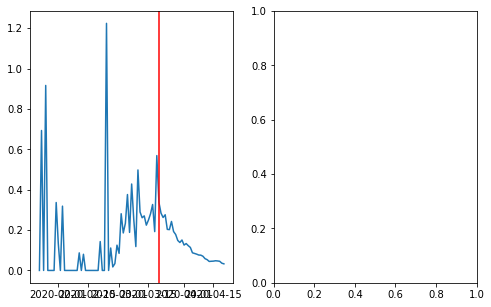

In [241]:
count_usa_vals = df_cases['US'].apply(lambda x : np.log(x)).values
diffs_usa = count_usa_vals[1:] - count_usa_vals[:-1]
count_china_vals = df_cases['China'].sum(axis=1).apply(lambda x : np.log(x)).values
diffs_china = count_china_vals[1:] - count_china_vals[:-1]
print(diffs_china)
fig, axes = plt.subplots(1, 2,figsize = (8,5))
ax11, ax21 = axes.ravel()
ax11.plot(df_cases.iloc[1:].index,diffs_usa)
ax11.axvline(datetime(2020,3,20),color='red')
ax12.plot(df_cases.iloc[1:].index,diffs_china)
